In [62]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import os
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM, GRU, Bidirectional, Dense, Dropout, Input

tf.__version__

'2.0.0'

In [104]:
print("\n".join(os.listdir("./")))
df = pd.read_csv('data/DJI_modified_sma.csv')

AIAlpha.ipynb
DJI_STO_20period_sma10.csv
seq2word_seq2seq.ipynb
.DS_Store
saved_model
preprocess
__pycache__
ARIMA_model.ipynb
README.md
baseline.ipynb
utils.py
Simulator
model_FE.ipynb
.ipynb_checkpoints
model_fe_too.ipynb
.git
data
tmp
Nikkie_NoFE.ipynb


In [105]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,sma5,sma10,sma25,sma75,sma125,sma200
0,1985-01-29,1277.719971,1295.489990,1266.890015,1292.619995,1292.619995,13560000,1292.619995,1292.619995,1292.619995,1292.619995,1292.619995,1292.619995
1,1985-01-30,1297.369995,1305.099976,1278.930054,1287.880005,1287.880005,16820000,1287.880005,1287.880005,1287.880005,1287.880005,1287.880005,1287.880005
2,1985-01-31,1283.239990,1293.400024,1272.640015,1286.770020,1286.770020,14070000,1286.770020,1286.770020,1286.770020,1286.770020,1286.770020,1286.770020
3,1985-02-01,1276.939941,1286.109985,1269.770020,1277.719971,1277.719971,10980000,1277.719971,1277.719971,1277.719971,1277.719971,1277.719971,1277.719971
4,1985-02-04,1272.079956,1294.939941,1268.989990,1290.079956,1290.079956,11630000,1287.013989,1290.079956,1290.079956,1290.079956,1290.079956,1290.079956


In [106]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume,sma5,sma10,sma25,sma75,sma125,sma200
count,8762.000000,8762.000000,8762.000000,8762.000000,8762.000000,8.762000e+03,8762.000000,8762.000000,8762.000000,8762.000000,8762.000000,8762.000000
mean,9741.540516,9800.407342,9680.969127,9744.180560,9744.180560,1.387696e+08,9738.288319,9730.964669,9709.143362,9636.784488,9564.918578,9458.638821
std,6379.993445,6406.101221,6351.951044,6380.505213,6380.505213,1.218227e+08,6375.645973,6369.877839,6353.093276,6298.411546,6243.063416,6160.864855
min,1243.709961,1251.209961,1235.530029,1242.050049,1242.050049,2.530000e+06,1246.420020,1253.411023,1261.478818,1242.050049,1242.050049,1242.050049
25%,3614.900086,3635.000000,3595.430053,3616.775024,3616.775024,2.666250e+07,3616.110974,3611.814222,3598.590109,3561.849625,3522.914113,3460.122220
50%,9958.229981,10031.165040,9873.945312,9958.939942,9958.939942,1.047850e+08,9955.690039,9966.947461,10013.490235,10006.442710,9937.613086,9844.902081
75%,12604.689700,12672.895020,12536.984863,12608.264892,12608.264892,2.266075e+08,12590.240043,12576.958180,12560.957970,12505.968420,12464.211825,12284.940260
max,27364.689450,27398.679690,27294.169920,27359.160160,27359.160160,2.190810e+09,27293.928120,27255.588090,27026.882730,26657.372450,26448.710060,26196.764980


In [107]:
df = df.drop('Adj Close', axis=1)

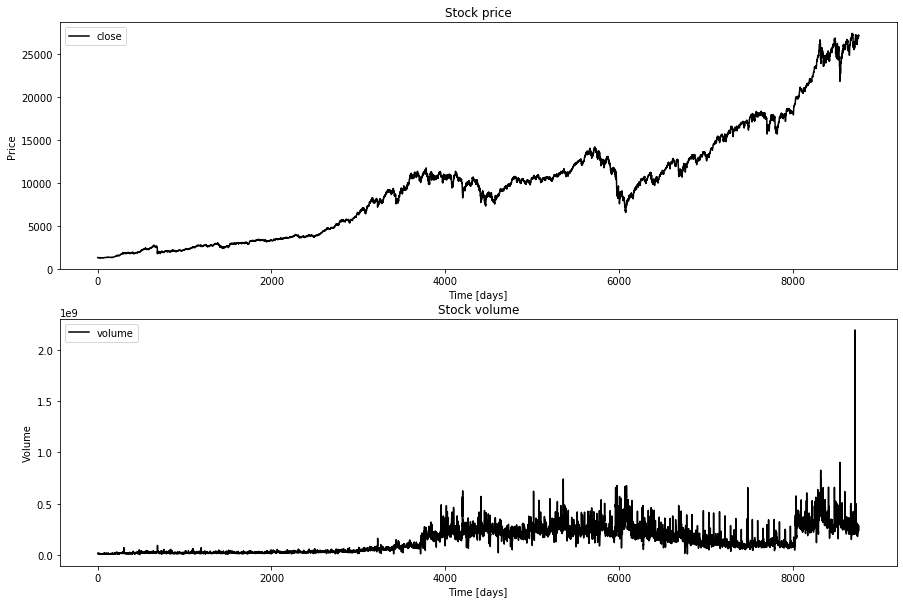

In [108]:
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)
plt.plot(df['Close'], color='black', label='close')
plt.title('Stock price')
plt.xlabel('Time [days]')
plt.ylabel('Price')
plt.legend(loc='best')


plt.subplot(2, 1, 2)
plt.plot(df['Volume'], color='black', label='volume')
plt.title('Stock volume')
plt.xlabel('Time [days]')
plt.ylabel('Volume')
plt.legend(loc='best')

In [109]:
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['Open'] = min_max_scaler.fit_transform(df['Open'].to_numpy().reshape(-1, 1))
    df['Low'] = min_max_scaler.fit_transform(df['Low'].to_numpy().reshape(-1, 1))    
    df['High'] = min_max_scaler.fit_transform(df['High'].to_numpy().reshape(-1, 1))    
    df['Close'] = min_max_scaler.fit_transform(df['Close'].to_numpy().reshape(-1, 1))
    df['sma5'] = min_max_scaler.fit_transform(df['sma5'].to_numpy().reshape(-1, 1))
    df['sma10'] = min_max_scaler.fit_transform(df['sma10'].to_numpy().reshape(-1, 1))
    df['sma25'] = min_max_scaler.fit_transform(df['sma25'].to_numpy().reshape(-1, 1))
    df['sma75'] = min_max_scaler.fit_transform(df['sma75'].to_numpy().reshape(-1, 1))
    df['sma125'] = min_max_scaler.fit_transform(df['sma125'].to_numpy().reshape(-1, 1))
    df['sma200'] = min_max_scaler.fit_transform(df['sma200'].to_numpy().reshape(-1, 1))
    #df['Volume'] = min_max_scaler.fit_transform(df['Volume'].to_numpy().reshape(-1, 1))  
    return df

def load_data(stock, seq_len):
    data_raw = stock.as_matrix()
    data = list()
    for index in range(len(data_raw) - seq_len):
        data.append(data_raw[index: index+seq_len])
    data = np.array(data)
    val_set_size = int(np.round(val_set_size_percentage/100*data.shape[0]))
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]))
    train_set_size = data.shape[0] - (val_set_size + test_set_size)
    
    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]
    
    x_val = data[train_set_size:train_set_size + val_set_size, :-1, :]
    y_val = data[train_set_size:train_set_size + val_set_size, -1, :]
    
    x_test = data[train_set_size+val_set_size:,:-1,:]
    y_test = data[train_set_size+val_set_size:,-1,:]
    
    return [x_train, y_train, x_val, y_val, x_test, y_test]

In [110]:
df_index = df.drop('Date', axis=1)
df_index = df_index.drop('Volume', axis=1)


cols = list(df_index.columns.values)
print('Col : ', cols)

# rearrange columns ,for training with volume
# n_cols = cols[:3] + [cols[-1]] + [cols[-2]]
# df_index = df_index[n_cols] 

# print("new Cols: ",list(df_index.columns.values))





# parameter for preprocessing #

val_set_size_percentage = 10
test_set_size_percentage = 10
seq_len = 20

#*****************************#

# normalize index
df_index_norm = normalize_data(df_index)

# split train, val, test data

x_train, y_train, x_val, y_val, x_test, y_test = load_data(df_index_norm, seq_len)

print('x_train.shape = ', x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_val.shape = ', x_val.shape)
print('y_val.shape = ', y_val.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ', y_test.shape)

Col :  ['Open', 'High', 'Low', 'Close', 'sma5', 'sma10', 'sma25', 'sma75', 'sma125', 'sma200']
x_train.shape =  (6994, 19, 10)
y_train.shape =  (6994, 10)
x_val.shape =  (874, 19, 10)
y_val.shape =  (874, 10)
x_test.shape =  (874, 19, 10)
y_test.shape =  (874, 10)


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:17: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [111]:
print(y_train[0]);
print("\n")
print(x_train[0]); 

[0.00124689 0.00160513 0.00141143 0.00168701 0.00130162 0.00112502
 0.00095598 0.0017336  0.00174795 0.0017656 ]


[[0.00130202 0.00169347 0.00120344 0.00193628 0.00177368 0.00150791
  0.00120864 0.00198974 0.00200621 0.00202647]
 [0.00205429 0.002061   0.00166548 0.00175479 0.00159171 0.00132562
  0.00102468 0.00180324 0.00181817 0.00183652]
 [0.00151334 0.00161354 0.0014241  0.00171229 0.00154909 0.00128293
  0.0009816  0.00175957 0.00177413 0.00179204]
 [0.00127216 0.00133474 0.00131396 0.00136577 0.00120165 0.00093488
  0.00063035 0.00140348 0.0014151  0.00142939]
 [0.0010861  0.00167244 0.00128403 0.00183902 0.00155846 0.00141023
  0.00111006 0.0018898  0.00190545 0.00192468]
 [0.00192757 0.00190917 0.00165281 0.00165332 0.00150172 0.0012237
  0.00092182 0.00169897 0.00171304 0.00173033]
 [0.00157651 0.00165561 0.00151734 0.00147566 0.00144574 0.00104526
  0.00074174 0.0015164  0.00152896 0.00154439]
 [0.00158072 0.00175275 0.00169925 0.00183902 0.00147116 0.00141023
  0.00111006 

In [112]:
df_index.head(20)

,Open,High,Low,Close,sma5,sma10,sma25,sma75,sma125,sma200
0,0.001302,0.001693,0.001203,0.001936,0.001774,0.001508,0.001209,0.001990,0.002006,0.002026
1,0.002054,0.002061,0.001665,0.001755,0.001592,0.001326,0.001025,0.001803,0.001818,0.001837
2,0.001513,0.001614,0.001424,0.001712,0.001549,0.001283,0.000982,0.001760,0.001774,0.001792
3,0.001272,0.001335,0.001314,0.001366,0.001202,0.000935,0.000630,0.001403,0.001415,0.001429
4,0.001086,0.001672,0.001284,0.001839,0.001558,0.001410,0.001110,0.001890,0.001905,0.001925
5,0.001928,0.001909,0.001653,0.001653,0.001502,0.001224,0.000922,0.001699,0.001713,0.001730
6,0.001577,0.001656,0.001517,0.001476,0.001446,0.001045,0.000742,0.001516,0.001529,0.001544
7,0.001581,0.001753,0.001699,0.001839,0.001471,0.001410,0.001110,0.001890,0.001905,0.001925
8,0.001775,0.001757,0.001759,0.001835,0.001565,0.001406,0.001106,0.001885,0.001901,0.001920
9,0.001695,0.001550,0.001271,0.001302,0.001458,0.001242,0.000566,0.001338,0.001349,0.001363


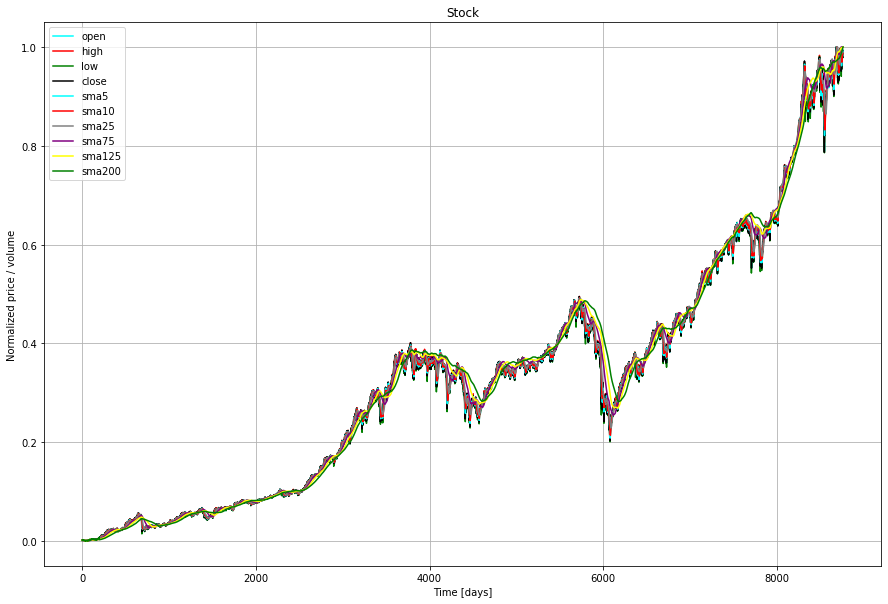

In [114]:
plt.figure(figsize=(15, 10))
plt.grid(True)
plt.plot(df_index_norm['Open'], color='cyan', label='open')
plt.plot(df_index_norm['High'], color='red', label='high')
plt.plot(df_index_norm['Low'], color='green', label='low')
plt.plot(df_index_norm['Close'], color='black', label='close')
plt.plot(df_index_norm['sma5'], color='cyan', label='sma5')
plt.plot(df_index_norm['sma10'], color='red', label='sma10')
plt.plot(df_index_norm['sma25'], color='gray', label='sma25')
plt.plot(df_index_norm['sma75'], color='purple', label='sma75')
plt.plot(df_index_norm['sma125'], color='yellow', label='sma125')
plt.plot(df_index_norm['sma200'], color='green', label='sma200')
plt.title('Stock')
plt.xlabel('Time [days]')
plt.ylabel('Normalized price / volume')
plt.legend(loc='best')
plt.show()

In [115]:
from tensorflow.keras import backend as K
K.clear_session()

In [117]:
from tensorflow.keras.layers import Bidirectional,TimeDistributed,BatchNormalization,Flatten,LeakyReLU,Dropout

def get_bi_gru():
    
    input1 = Input(shape=(19,10,))
    x = Bidirectional(LSTM(256, return_sequences=True,  kernel_initializer='Orthogonal'))(input1)
    x = TimeDistributed(LeakyReLU())(x)
    x = TimeDistributed(BatchNormalization())(x)
    x = GRU(128,kernel_initializer='Orthogonal')(x)
    x =(LeakyReLU())(x)
    x = (BatchNormalization())(x)
    x = (Dropout(0.25))(x)
    out = Dense(10,kernel_initializer='he_normal')(x)

    
    
    model = Model(inputs=input1, outputs=out)
    model.compile(optimizer=Adam(0.005),
                loss='mse',
                metrics=['mse'])   
    
    return model

In [118]:
model = get_bi_gru()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 19, 10)]          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 19, 512)           546816    
_________________________________________________________________
time_distributed (TimeDistri (None, 19, 512)           0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 19, 512)           2048      
_________________________________________________________________
gru (GRU)                    (None, 128)               246528    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512   

In [119]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
print('start training ')


weight_path_model = "saved_model/model_sma_NoVOL.h5"
callbacks_list_model = [
    ModelCheckpoint(
             weight_path_model,
            save_best_only=True,
            save_weights_only=True,
            monitor='val_loss',
            mode='min',
            verbose=2
        ),
    ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=4, min_lr=0.0001)
]

#################
batch_size = 64
epochs = 30
#################

history = model.fit(x_train, y_train, epochs=epochs, verbose=1, callbacks=callbacks_list_model,
          validation_data=(x_val, y_val),batch_size=batch_size) #batch_size=batch_size




start training 
Train on 6994 samples, validate on 874 samples
Epoch 1/30
6976/6994 [============================>.] - ETA: 0s - loss: 0.3211 - mse: 0.3211
Epoch 00001: val_loss improved from inf to 0.13164, saving model to saved_model/model_sma_NoVOL.h5
6994/6994 [==============================] - 33s 5ms/sample - loss: 0.3205 - mse: 0.3205 - val_loss: 0.1316 - val_mse: 0.1316
Epoch 2/30
6976/6994 [============================>.] - ETA: 0s - loss: 0.0520 - mse: 0.0520
Epoch 00002: val_loss improved from 0.13164 to 0.09131, saving model to saved_model/model_sma_NoVOL.h5
6994/6994 [==============================] - 23s 3ms/sample - loss: 0.0519 - mse: 0.0519 - val_loss: 0.0913 - val_mse: 0.0913
Epoch 3/30
6976/6994 [============================>.] - ETA: 0s - loss: 0.0132 - mse: 0.0132
Epoch 00003: val_loss improved from 0.09131 to 0.07768, saving model to saved_model/model_sma_NoVOL.h5
6994/6994 [==============================] - 28s 4ms/sample - loss: 0.0132 - mse: 0.0132 - val_loss: 

6976/6994 [============================>.] - ETA: 0s - loss: 7.3724e-04 - mse: 7.3724e-04
Epoch 00028: val_loss did not improve from 0.00061
6994/6994 [==============================] - 23s 3ms/sample - loss: 7.3740e-04 - mse: 7.3740e-04 - val_loss: 0.0047 - val_mse: 0.0047
Epoch 29/30
6976/6994 [============================>.] - ETA: 0s - loss: 6.2728e-04 - mse: 6.2728e-04
Epoch 00029: val_loss did not improve from 0.00061
6994/6994 [==============================] - 24s 3ms/sample - loss: 6.2730e-04 - mse: 6.2730e-04 - val_loss: 0.0012 - val_mse: 0.0012
Epoch 30/30
6976/6994 [============================>.] - ETA: 0s - loss: 6.4581e-04 - mse: 6.4581e-04
Epoch 00030: val_loss did not improve from 0.00061
6994/6994 [==============================] - 28s 4ms/sample - loss: 6.5040e-04 - mse: 6.5040e-04 - val_loss: 0.0028 - val_mse: 0.0028


In [134]:
print(history.history.keys())

dict_keys(['loss', 'mse', 'val_loss', 'val_mse', 'lr'])


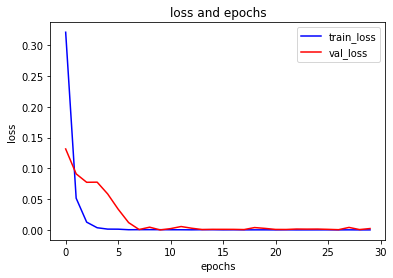

In [135]:
plt.title("loss and epochs")
plt.plot(history.history['loss'],color = 'blue',label="train_loss")
plt.plot(history.history['val_loss'],color = 'red',label="val_loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()


In [136]:
# #Load the minimum loss weight 
# model = get_bi_gru()
# model.load_weights("./saved_model/the_best_one.h5")

In [137]:
# # Load saved model 
# from tensorflow.keras.models import load_model
# model = load_model("./saved_model/the_best_one.h5")

In [138]:
x_train.shape
y_train.shape

(6994, 10)

In [139]:
y_train_pred = model.predict(x_train)
y_val_pred = model.predict(x_val)
y_test_pred = model.predict(x_test)

In [140]:
print(y_test_pred[0])

[0.6519195  0.6094921  0.63684714 0.6047287  0.6664737  0.62588245
 0.6433016  0.6024617  0.5753908  0.5191194 ]


In [141]:
print( y_test_pred[:, 1][0])

0.6094921


In [142]:
def plot_compare(x):
    Col = {'Open':0, 'High':1, 'Low':2, 'Close':3}
    ft = Col[x]
    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)

    plt.plot(np.arange(y_train.shape[0]), y_train[:, ft], color='blue', label='train target')

    plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_val.shape[0]), y_val[:, ft], 
             color='gray', label='val target')
    plt.plot(np.arange(y_train.shape[0] + y_val.shape[0], y_train.shape[0] + y_val.shape[0] + y_test.shape[0]),
            y_test[:, ft], color='black', label='test target')
    plt.plot(np.arange(y_train_pred.shape[0]), y_train_pred[:, ft],
            color='red', label='train prediction') 
    plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0] + y_val_pred.shape[0]),
            y_val_pred[:, ft], color='orange', label='val prediction')
    plt.plot(np.arange(y_train_pred.shape[0] + y_val_pred.shape[0],
            y_train_pred.shape[0] + y_val_pred.shape[0] + y_test_pred.shape[0]),
            y_test_pred[:, ft], color ='green', label='test prediction')
    plt.title('past and future stock price')
    plt.xlabel('Time [Days]')
    plt.ylabel('Normalized price')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_test.shape[0]),
            y_test[:, ft], color='black', label='test target')
    plt.plot(np.arange(y_train.shape[0], y_train.shape[0] + y_test_pred.shape[0]),
            y_test_pred[:, ft], color='green', label='test prediction')
    plt.title('future stock prices '+x)
    plt.xlabel('Time [Days]')
    plt.ylabel('Normalized price')
    plt.legend(loc='best')



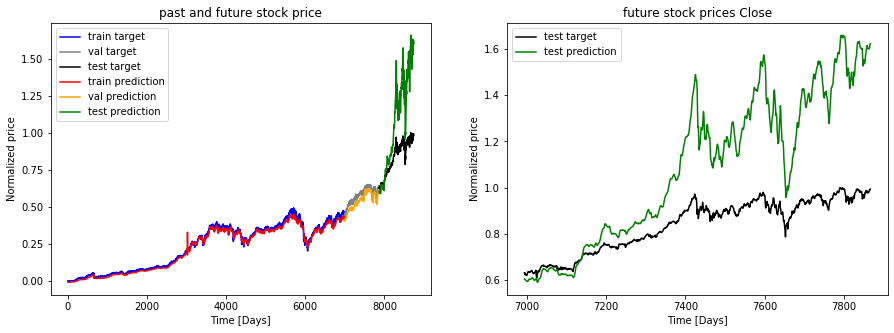

In [143]:
plot_compare('Close')

In [144]:
#model.save("saved_model/best_one.h")

In [131]:
model.evaluate(x_test,y_test)

874/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.20439213231308237, 0.2043921]

In [132]:
model.evaluate(x_val,y_val)

874/1 [=================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.002834395349379501, 0.0028343957]

In [133]:
model.evaluate(x_train,y_train)

6994/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

[0.0006687783812656615, 0.00066877843]